In [2]:
import os

DATA_DIR = os.path.join(os.path.abspath('..'), 'data')
DATA_NAME = 'healthcare-dataset-stroke-data.csv'

In [3]:
import pandas as pd

raw_data = pd.read_csv(os.path.join(DATA_DIR, DATA_NAME))
raw_data.drop('id', axis=1, inplace=True)


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [5]:
print(raw_data['work_type'].value_counts())
print(raw_data['Residence_type'].value_counts())
print(raw_data['smoking_status'].value_counts())

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64


In [6]:
raw_data.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


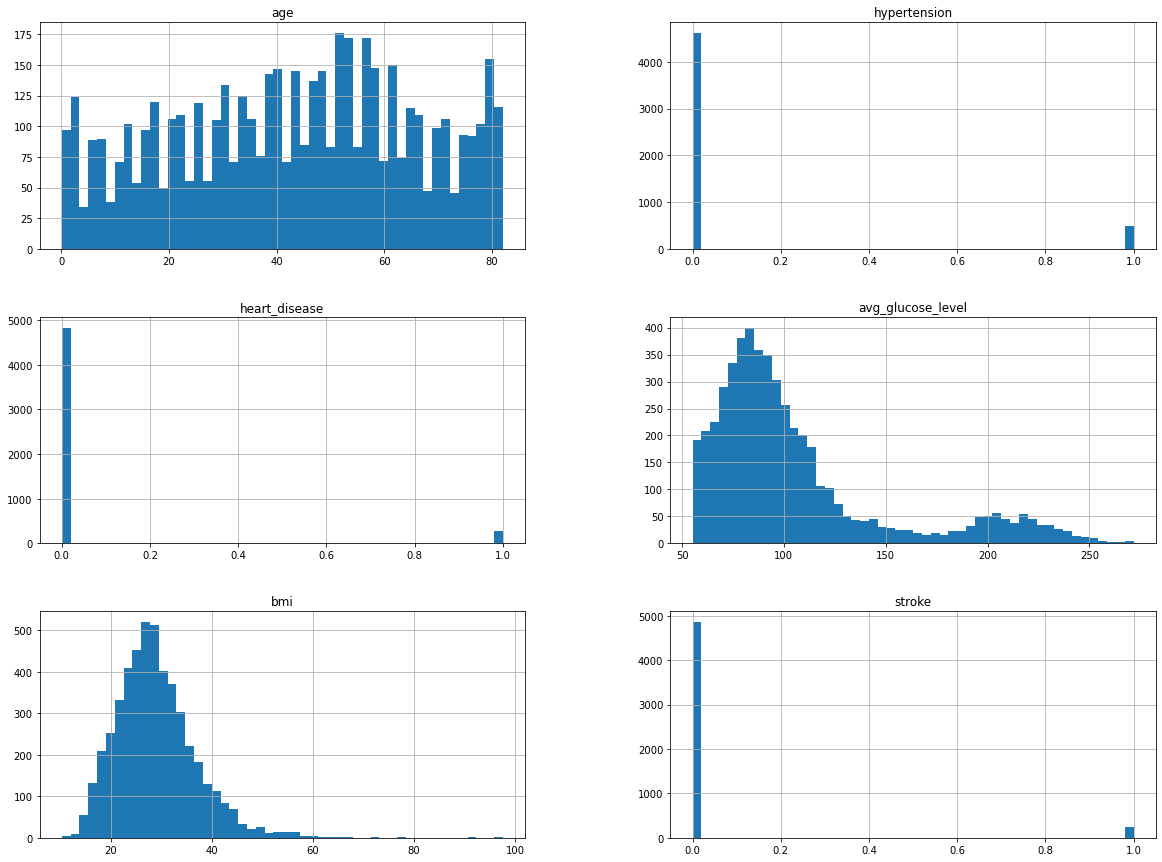

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
raw_data.hist(bins=50, figsize=(20,15))
plt.show()

0    4861
1    4861
Name: stroke, dtype: int64
ratio: 1.0:1.0


<AxesSubplot:>

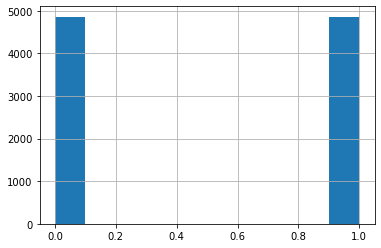

In [22]:
#This is clearly an imbalanced class (skewed datasets)

class_count = stroke_features['stroke'].value_counts()

print(class_count)
print('ratio: ' + str(class_count[0]/class_count[1]) + ':' + str(class_count[1]/class_count[1]))

raw_data['stroke'].hist()


In [9]:
# from sklearn.utils import resample
#
# false_class = raw_data[raw_data['stroke'] == 0].copy()
# true_class = raw_data[raw_data['stroke'] == 1].copy()
#
# true_class_resampled = resample(true_class,
#                                  replace=True,
#                                  n_samples=len(false_class),
#                                  random_state=22)
#
# raw_data = pd.concat([true_class_resampled, false_class])
#



In [10]:
corr_matrix = raw_data.corr()
corr_matrix['stroke'].sort_values(ascending=False)

stroke               1.000000
age                  0.245257
heart_disease        0.134914
avg_glucose_level    0.131945
hypertension         0.127904
bmi                  0.042374
Name: stroke, dtype: float64

In [11]:
stroke_features = raw_data.drop(['bmi', 'stroke'], axis=1)
stroke_labels = raw_data['stroke'].copy()

In [13]:
from sklearn.preprocessing import OrdinalEncoder

scaler = OrdinalEncoder()
smote_features = scaler.fit_transform(stroke_features[['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']])

In [15]:
stroke_features[['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']] = smote_features

In [16]:
stroke_features

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,smoking_status
0,1.0,67.0,0,1,1.0,2.0,1.0,228.69,1.0
1,0.0,61.0,0,0,1.0,3.0,0.0,202.21,2.0
2,1.0,80.0,0,1,1.0,2.0,0.0,105.92,2.0
3,0.0,49.0,0,0,1.0,2.0,1.0,171.23,3.0
4,0.0,79.0,1,0,1.0,3.0,0.0,174.12,2.0
...,...,...,...,...,...,...,...,...,...
5105,0.0,80.0,1,0,1.0,2.0,1.0,83.75,2.0
5106,0.0,81.0,0,0,1.0,3.0,1.0,125.20,2.0
5107,0.0,35.0,0,0,1.0,3.0,0.0,82.99,2.0
5108,1.0,51.0,0,0,1.0,2.0,0.0,166.29,1.0


In [17]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
stroke_features, stroke_labels = smote.fit_resample(stroke_features, stroke_labels)

In [ ]:
stroke_features.isnull().count()

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

for featureName in stroke_features.select_dtypes(include='O'):
    feature = stroke_features[[featureName]]
    orc_enc = OrdinalEncoder()
    encoded_feature = orc_enc.fit_transform(feature)
    stroke_features[featureName + '_encoded'] = encoded_feature

stroke_features = stroke_features.select_dtypes(exclude='O')

In [ ]:
stroke_features.info()

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(stroke_features, stroke_labels, random_state=22, test_size=0.2)

from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)

In [31]:
from sklearn.svm import SVC

svc_clf = SVC(gamma='auto', random_state=22)
svc_clf.fit(X_train, y_train)

SVC(gamma='auto', random_state=22)

In [32]:
X_test = std_scaler.transform(X_test)

from sklearn.model_selection import cross_val_score


cross_val_score(svc_clf, X_test, y_test, cv=3, scoring='roc_auc')

array([0.93292637, 0.91687569, 0.91816318])

In [34]:
from sklearn.metrics import confusion_matrix

predictions_test = svc_clf.predict(X_test)

print(confusion_matrix(y_test, predictions_test))

[[884 122]
 [122 817]]


In [36]:
from tensorflow import keras

model = keras.models.Sequential([
    keras.layers.Dense(128, activation=keras.activations.relu, input_shape=[9]),
    keras.layers.Dense(128, activation=keras.activations.relu),
    keras.layers.Dense(128, activation=keras.activations.relu),
    keras.layers.Dense(1, activation=keras.activations.sigmoid)
])

In [37]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.Recall()])

In [38]:
model.fit(X_train, y_train,epochs=1000, callbacks=[keras.callbacks.EarlyStopping(patience=10)])


Epoch 1/1000
244/244 [==============================] - 0s 887us/step - loss: 0.6109 - recall: 0.6996
Epoch 2/1000
244/244 [==============================] - 0s 869us/step - loss: 0.5049 - recall: 0.8220
Epoch 3/1000
244/244 [==============================] - 0s 820us/step - loss: 0.4539 - recall: 0.8325
Epoch 4/1000
244/244 [==============================] - 0s 980us/step - loss: 0.4341 - recall: 0.8368
Epoch 5/1000
244/244 [==============================] - 0s 984us/step - loss: 0.4228 - recall: 0.8312
Epoch 6/1000
244/244 [==============================] - 0s 861us/step - loss: 0.4133 - recall: 0.8353
Epoch 7/1000
244/244 [==============================] - 0s 918us/step - loss: 0.4056 - recall: 0.8406
Epoch 8/1000
244/244 [==============================] - 0s 959us/step - loss: 0.3982 - recall: 0.8391
Epoch 9/1000
244/244 [==============================] - 0s 885us/step - loss: 0.3909 - recall: 0.8496
Epoch 10/1000
244/244 [==============================] - 0s 910us/step - loss: 0.3

In [39]:
model.evaluate(X_test, y_test)

61/61 [==============================] - 0s 689us/step - loss: 0.5083 - recall: 0.8328


[0.5082993507385254, 0.8328008651733398]

In [ ]:

predictions_train = (model.predict(X_train) > 0.5).astype('int32')
predictions_valid = (model.predict(X_valid) > 0.5).astype('int32')
predictions_test = (model.predict(X_test) > 0.5).astype('int32')

print(confusion_matrix(y_train, predictions_train))
print(confusion_matrix(y_valid, predictions_valid))
print(confusion_matrix(y_test, predictions_test))

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(accuracy_score(y_test, predictions_test))
print(precision_score(y_test, predictions_test))
print(recall_score(y_test, predictions_test))
print(f1_score(y_test, predictions_test))


0.8745501285347044
0.8700745473908413
0.8700745473908413
0.8700745473908413
